# Quantium Virtual Internship - Task 1

### Setup

In [1]:
# Handling data
import pandas as pd
import numpy as np

# Library for operations on strings
import re

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Style setup
import matplotlib as mpl
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 16)
mpl.rc('ytick', labelsize = 12)
plt.style.use('fivethirtyeight')

### Load the data

In this cell i am going to load the data. Since the columns name of the two files are written in capital letter, i decided to apply a function to transform them into a more conventional format (first letter in capital case, everything else in lower).

In [2]:
purch_df = pd.read_csv(r'C:\Users\Aless\Downloads\QVI_purchase_behaviour.csv')
trans_df = pd.read_excel(r'C:\Users\Aless\Downloads\QVI_transaction_data.xlsx')

purch_df.columns = purch_df.columns.map(lambda x: x[0].upper() + x[1:].lower())
trans_df.columns = trans_df.columns.map(lambda x: x[0].upper() + x[1:].lower())

### Data validation

First of all i am going to check the data type of each column

In [3]:
purch_df.dtypes

Lylty_card_nbr       int64
Lifestage           object
Premium_customer    object
dtype: object

In [4]:
trans_df.dtypes

Date                int64
Store_nbr           int64
Lylty_card_nbr      int64
Txn_id              int64
Prod_nbr            int64
Prod_name          object
Prod_qty            int64
Tot_sales         float64
dtype: object

Dates are formatted as 5 digits integers: to cast them as dates i will create a function using the datetime library

In [5]:
import datetime as dt

def cast_date(date):
    return dt.datetime(1899, 12, 30) + dt.timedelta(days= date)

trans_df['Date'] = trans_df['Date'].apply(cast_date)

Now i can run some analysis on the transaction distribution over the given time frame: as we can see we have a significant peak in orders around the end of december (first chart). In the second plot we can see that the increase happens the days before Christmas, probably due to the high consumption of chips during this type of holydays. We can also see how we do not have data for the 25 of december, since supermarkets are close in that day. 

364


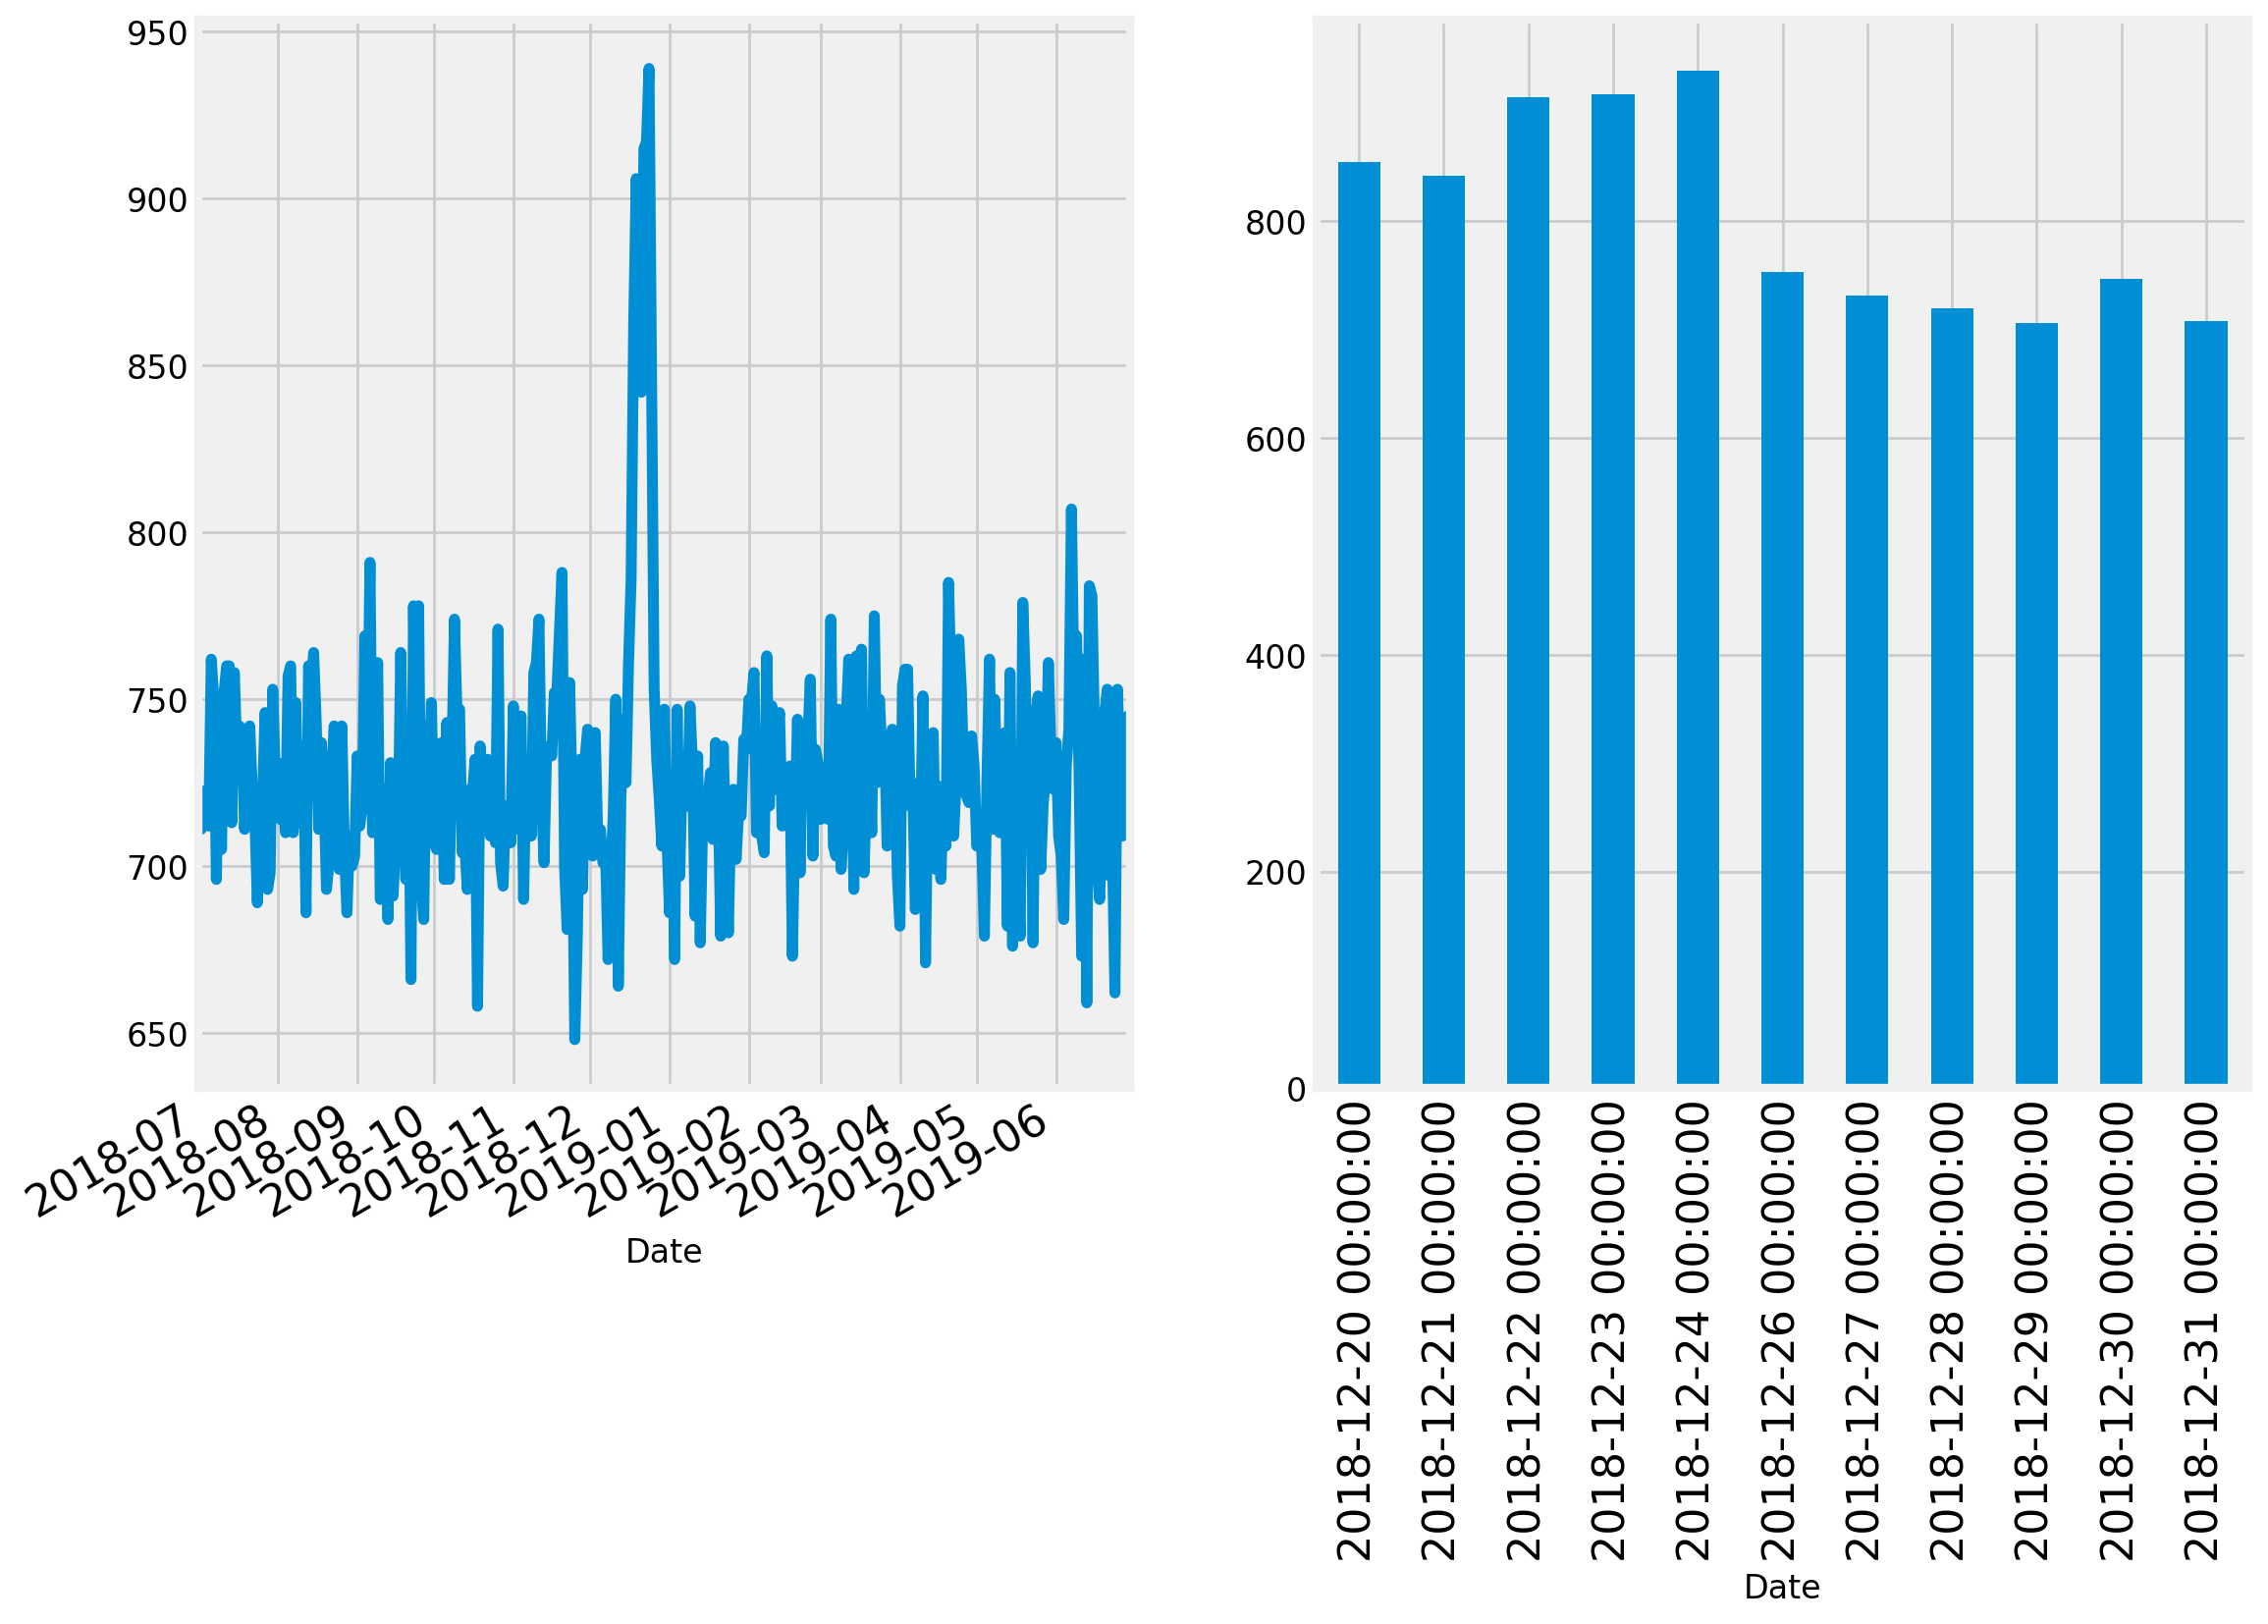

In [6]:
grouped = trans_df.groupby('Date')['Date'].count()
print(len(grouped))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 8), dpi = 200)
grouped.plot(ax = ax1)
grouped.loc[dt.datetime(2018, 12, 20) : dt.datetime(2018, 12, 31)].plot(kind = 'bar', ax = ax2)

The maximum number of orders is on the 24 of december, the day before Christmas. This support the theory according to which people are buying more chips for their Christmas family lunch.

In [7]:
grouped.loc[grouped == max(grouped)]

Date
2018-12-24    939
Name: Date, dtype: int64

#### Missing values

We do not have missing values in both of the dataframes

In [8]:
def check_na(df):
    print(df.isna().apply(sum))

check_na(purch_df)
print()
check_na(trans_df)

Lylty_card_nbr      0
Lifestage           0
Premium_customer    0
dtype: int64

Date              0
Store_nbr         0
Lylty_card_nbr    0
Txn_id            0
Prod_nbr          0
Prod_name         0
Prod_qty          0
Tot_sales         0
dtype: int64


#### Duplicates

Now i check for duplicated values: the following code computes the total number of duplicates in each columns. Even though we have data about every variable, duplicates are not relevant when we look for example to Product number, but i want to be sure that we do not have two identical loyalty card number in the purchase beha viour datasets (in the transaction one it is normal that the same ID is linked to multiple transactions).

In [9]:
def check_duplicates(df):
    duplicate = {}
    for column in df.columns:
        duplicate[column] = df[column].duplicated().sum()
    for key, values in duplicate.items():
        print('Number of duplicates in {}: {}'.format(key, values))
    print('')
        
check_duplicates(purch_df)
check_duplicates(trans_df)

Number of duplicates in Lylty_card_nbr: 0
Number of duplicates in Lifestage: 72630
Number of duplicates in Premium_customer: 72634

Number of duplicates in Date: 264472
Number of duplicates in Store_nbr: 264564
Number of duplicates in Lylty_card_nbr: 192199
Number of duplicates in Txn_id: 1709
Number of duplicates in Prod_nbr: 264722
Number of duplicates in Prod_name: 264722
Number of duplicates in Prod_qty: 264830
Number of duplicates in Tot_sales: 264724



### Outliers

The next step is tho check for outliers in the numeric variables. Let us start from the ordered quantity.

In [10]:
trans_df.Prod_qty.describe([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    264836.000000
mean          1.907309
std           0.643654
min           1.000000
25%           2.000000
50%           2.000000
75%           2.000000
90%           2.000000
95%           2.000000
99%           2.000000
max         200.000000
Name: Prod_qty, dtype: float64

We can see as most of the values are 1 of 2. We have an outlier identified as 200 packs of chips. I will go ahead analyzing the sales to see if there i will find a match

In [11]:
trans_df.Tot_sales.describe([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    264836.000000
mean          7.304200
std           3.083226
min           1.500000
25%           5.400000
50%           7.400000
75%           9.200000
90%          10.800000
95%          11.400000
99%          13.000000
max         650.000000
Name: Tot_sales, dtype: float64

Let us investigate further about these orders

In [12]:
trans_df.loc[trans_df['Tot_sales'] == max(trans_df.Tot_sales)]

,Date,Store_nbr,Lylty_card_nbr,Txn_id,Prod_nbr,Prod_name,Prod_qty,Tot_sales
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


We have just two transactions related to this customer, with about 9 months of distance between them. Clearly it is not a private buyer (it can be a small bar which makes a large order of chips few days before the stock out) so i will eliminate its transactions from the analysis.

In [13]:
trans_df.drop(trans_df.loc[trans_df['Tot_sales'] == max(trans_df.Tot_sales)].index, axis = 0, inplace = True)

In order to make a complete analysis i am going to compute the unitary price for pack of chips on each transaction. Then will use some visualization to check for outliers.

Text(0.5, 0.98, 'Unitary price distribution')

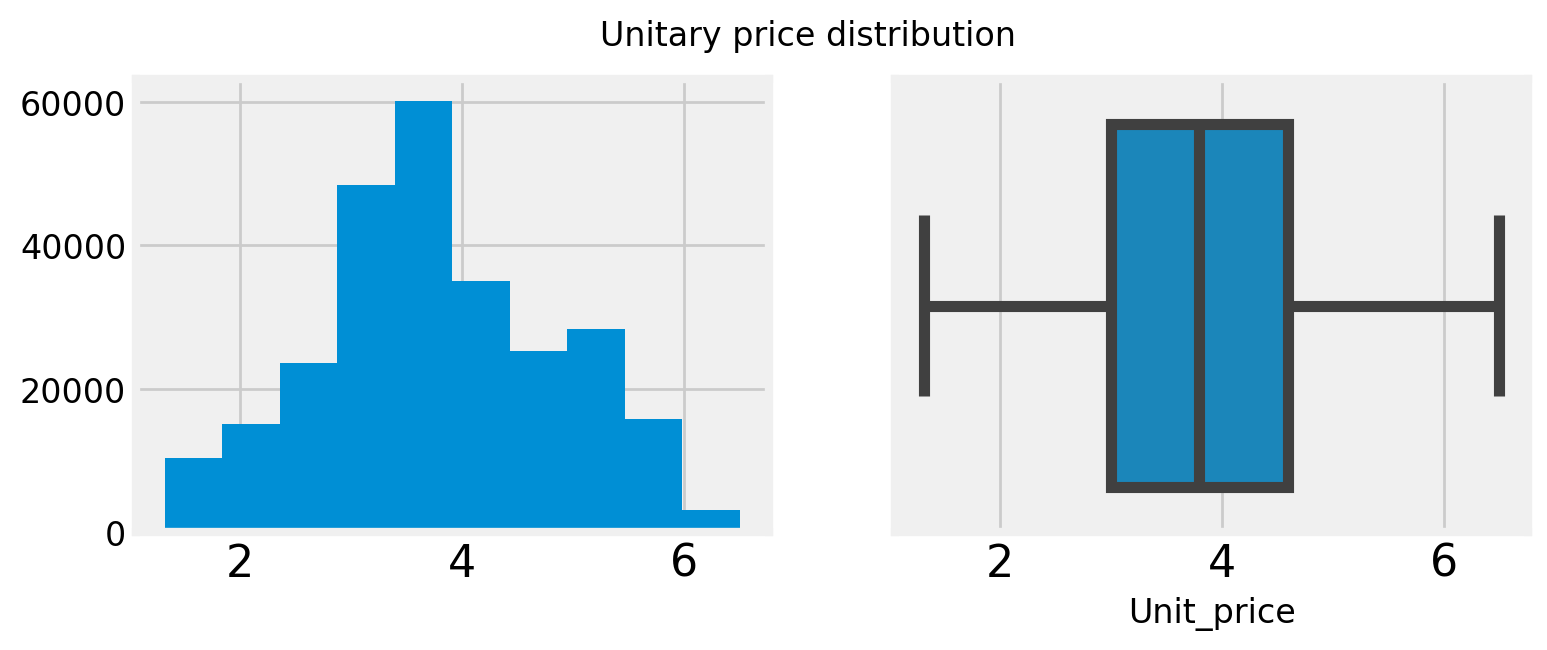

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 3), dpi = 200)
trans_df['Unit_price'] = trans_df['Tot_sales'] / trans_df['Prod_qty']
ax1.hist(trans_df['Unit_price'], bins = 10)
sns.boxplot(trans_df['Unit_price'], ax = ax2)
plt.suptitle('Unitary price distribution')

### Feature extraction

It is time to work on the product name. First let us give a look to some of them

In [15]:
trans_df['Prod_name'].head(20)

0       Natural Chip        Compny SeaSalt175g
1                     CCs Nacho Cheese    175g
2       Smiths Crinkle Cut  Chips Chicken 170g
3       Smiths Chip Thinly  S/Cream&Onion 175g
4     Kettle Tortilla ChpsHny&Jlpno Chili 150g
5     Old El Paso Salsa   Dip Tomato Mild 300g
6     Smiths Crinkle Chips Salt & Vinegar 330g
7        Grain Waves         Sweet Chilli 210g
8      Doritos Corn Chip Mexican Jalapeno 150g
9        Grain Waves Sour    Cream&Chives 210G
10    Smiths Crinkle Chips Salt & Vinegar 330g
11       Kettle Sensations   Siracha Lime 150g
12                    Twisties Cheese     270g
13            WW Crinkle Cut      Chicken 175g
14              Thins Chips Light&  Tangy 175g
15                           CCs Original 175g
16                           Burger Rings 220g
17      NCC Sour Cream &    Garden Chives 175g
18     Doritos Corn Chip Southern Chicken 150g
19                    Cheezels Cheese Box 125g
Name: Prod_name, dtype: object

The first thing i notice is that there is not a standard format for the product name. Work with text data in this situation it is often hard, so i will use the following empirical assumption to extract features:

The size of the pack is always the last 'word' of the string

The flavour is immediately before the size

The first word usually refers to the brand name 

Using all of these hypothesis i can start to extract features. Note that there are many grammatical errors in this strings and no one of my assumptions is useful to solve the criticality. The 'greed' approach we can implement in this case is to find most common mistakes through a counter and manually correct them. Obviously this solution will require a lot of time and it will probably lead to a sub optimal solution. The other (and more correct) way to face this is to use natural language processing tools, such as a grammar checker. Although there a lot of pre-trained applications for this task (i.e. SpellChecker or grammar-check), the product name strings often contains special words such as the brand name (i.e. Kettle, Thins)  and the flavour (i.e. ChpsHny&Jlpno) so it will be difficult for them to analyze this terms. The best solution is to build a grammar checker from scratch, using nltk (natural language tool-kit) and training it on large amount of food product name. This will require a remarkable amount of time but we can keep it in mind for future improvements to our analysis 

In [16]:
def extract_weight(x):
    return re.findall("\d+", x)[0]

def extract_prod_name(x):
    return " ".join(re.findall("[a-zA-Z]+", x))[:-1]

def extract_flavour(x):
    return x.split()[-1]

def extract_brand(x):
    return x.split()[0]

trans_df['Weight'] = trans_df['Prod_name'].apply(extract_weight).astype('int')
trans_df['Prod_name'] = trans_df['Prod_name'].apply(extract_prod_name)
trans_df['Flavour'] = trans_df['Prod_name'].apply(extract_flavour)
trans_df['Brand'] = trans_df['Prod_name'].apply(extract_brand)
trans_df.drop('Prod_name', 1, inplace = True)

Let us give a look to the generated feature to see if i extracted some useful information.

In [17]:
trans_df['Weight'].describe()

count    264834.000000
mean        182.425512
std          64.325148
min          70.000000
25%         150.000000
50%         170.000000
75%         175.000000
max         380.000000
Name: Weight, dtype: float64

Now i will take a look at the brand with most occurences: as expected some words do not refer to actual brands ('Old' or 'Natural'), anyway i managed to extract useful information for most of them so i will keep the column in the dataframe

In [18]:
from collections import Counter

w_counter = Counter()
for prod in trans_df['Brand']:
    words = prod.split()
    w_counter.update(words)
    
trans_df.reset_index(inplace = True, drop = True)
w_counter.most_common()[:20]

[('Kettle', 41288),
 ('Smiths', 28860),
 ('Pringles', 25102),
 ('Doritos', 24962),
 ('Thins', 14075),
 ('RRD', 11894),
 ('Infuzions', 11057),
 ('WW', 10320),
 ('Cobs', 9693),
 ('Tostitos', 9471),
 ('Twisties', 9454),
 ('Old', 9324),
 ('Tyrrells', 6442),
 ('Grain', 6272),
 ('Natural', 6050),
 ('Red', 5885),
 ('Cheezels', 4603),
 ('CCs', 4551),
 ('Woolworths', 4437),
 ('Dorito', 3183)]

In [19]:
trans_df.Flavour.value_counts()[:20]

Chips        17085
Chicken      15473
Original     15421
Cheese       13973
Vinegar      12402
Supreme       9452
Lime          7874
Chives        7792
Salted        6248
Chilli        6205
Cream         6177
Onion         6116
Mild          4557
Salsa         4391
Pesto         3304
Chili         3296
Sal           3257
PotatoMix     3242
Bag           3233
Spicy         3229
Name: Flavour, dtype: int64

We have many transactions related to 'Salsa' flavour. We can see them as operations related to other type of products, let us implement a function to drop them

In [20]:
def remove_lines(df, word):
    index = []
    for i in range(df.shape[0]):
        if word in df.Flavour[i].split():
            index.append(i)
    df.drop(index, axis = 0, inplace = True)
    return df

trans_df = remove_lines(trans_df, 'Salsa')
trans_df.shape

(260443, 11)

Last we have a grammar mistake on the word Chilli: I decided to update its value to Chili

In [21]:
filt = trans_df.Flavour == 'Chilli'
trans_df.loc[filt, 'Flavour'] = 'Chili'

### Merging two datasets

In [22]:
df = trans_df.set_index('Lylty_card_nbr').join(purch_df.set_index('Lylty_card_nbr'))

### Data analysis

In [23]:
df.head()

,Date,Store_nbr,Txn_id,Prod_nbr,Prod_qty,Tot_sales,Unit_price,Weight,Flavour,Brand,Lifestage,Premium_customer
Lylty_card_nbr,,,,,,,,,,,,
1000,2018-10-17,1,1,5,2,6.0,3.0,175,SeaSalt,Natural,YOUNG SINGLES/COUPLES,Premium
1002,2018-09-16,1,2,58,1,2.7,2.7,150,Aioli,Red,YOUNG SINGLES/COUPLES,Mainstream
1003,2019-03-07,1,3,52,1,3.6,3.6,210,Chives,Grain,YOUNG FAMILIES,Budget
1003,2019-03-08,1,4,106,1,3.0,3.0,175,Chckn,Natural,YOUNG FAMILIES,Budget
1004,2018-11-02,1,5,96,1,1.9,1.9,160,Chips,WW,OLDER SINGLES/COUPLES,Mainstream


First let us try to understand our customers. This chart shows the number of transaction (normalized to a percentage of total orders) made by each of the 'premium_customer' segment

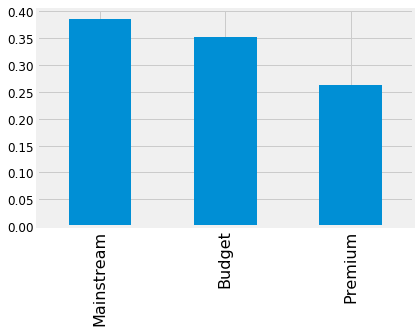

In [24]:
df.Premium_customer.value_counts(normalize = True).plot(kind = 'bar')

We can deep dive and try to understand the distribution of premium customer among each of the Lifestage categories

Text(0.5, 0.98, 'Premium customer distribution among Lifestage')

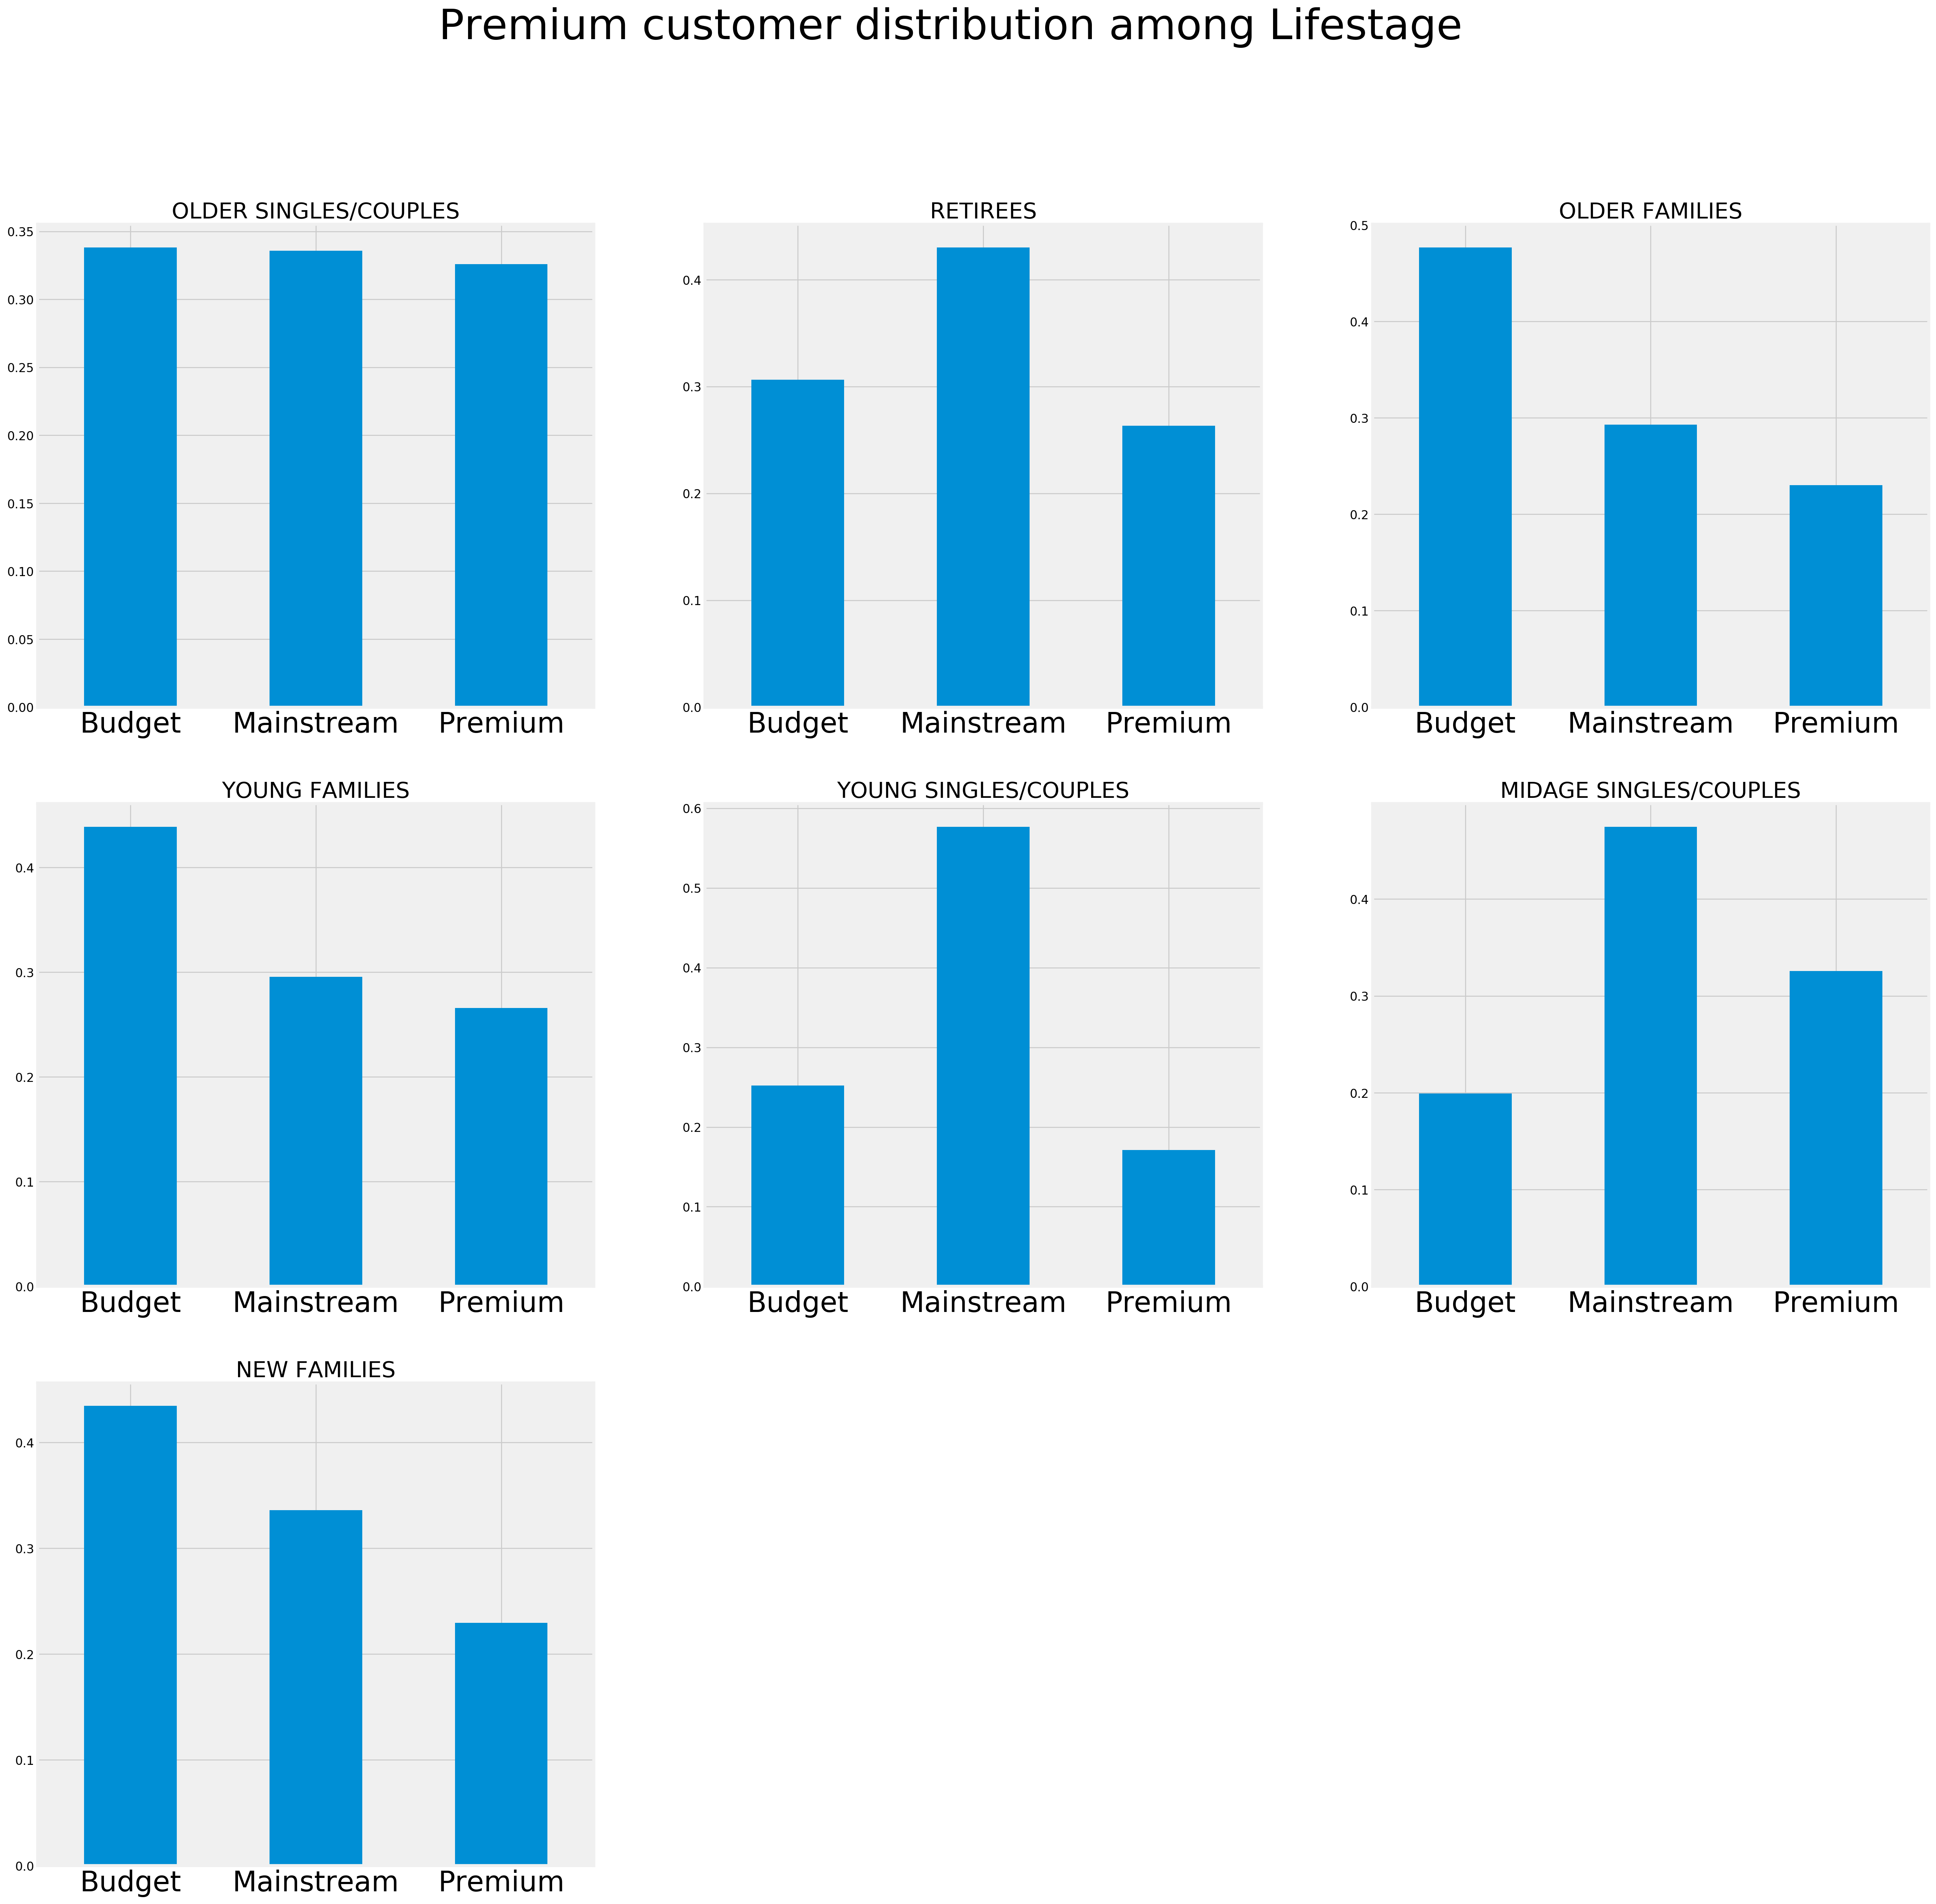

In [25]:
# Setting matplotlib font
font = {'size' : 35}
mpl.rc('font', **font)
# Creating axes variables
ax_nmr = len(df.Lifestage.value_counts())
col = 3
row = (ax_nmr // col) + min([1, ax_nmr % col])
# Creating the axes
fig = plt.figure(figsize = (30, 30), dpi = 20y0)
axes = {}
for i in range(1, ax_nmr + 1):
    axes['ax' + str(i)] = fig.add_subplot(row, col, i)
# Plotting the data
categories = list(df.Lifestage.value_counts().index)
labels = list(df.Premium_customer.value_counts().sort_index().index)
for cat in categories:
    df.loc[df.Lifestage == cat].Premium_customer.value_counts(normalize = True).sort_index().plot(kind = 'bar',
                                                                                                  ax = axes['ax' + str(categories.index(cat) + 1)])
    axes['ax' + str(categories.index(cat) + 1)].set_title(cat, fontsize = 22)
    axes['ax' + str(categories.index(cat) + 1)].set_xticklabels(labels, fontsize = 28)
    for tick in axes['ax' + str(categories.index(cat) + 1)].get_xticklabels():
        tick.set_rotation(0)

plt.suptitle('Premium customer distribution among Lifestage')

The first key point we can extract from this analysis is that in all 'family' categories the budget segment is the most present: This can be imputed to the general will of saving among them, since it is likely that this kind of household are more numeros than the others and so there is a higher need of money. Another insight is about midage single/couple and older. There is a strong presence of premium customer among them and this can be translated in higher revenue. Since it could be difficult to operate a this very specific level, we can aggregate data to a hgiher one, making a distinction between families and single/couples. I decided to make this distinction since families' household are very likely to have more than 2 components, otherwise all the other Lifestage categories households are probably constituted by just 2 people.

Text(0.5, 1.0, 'Singles/Couples/Retirees')

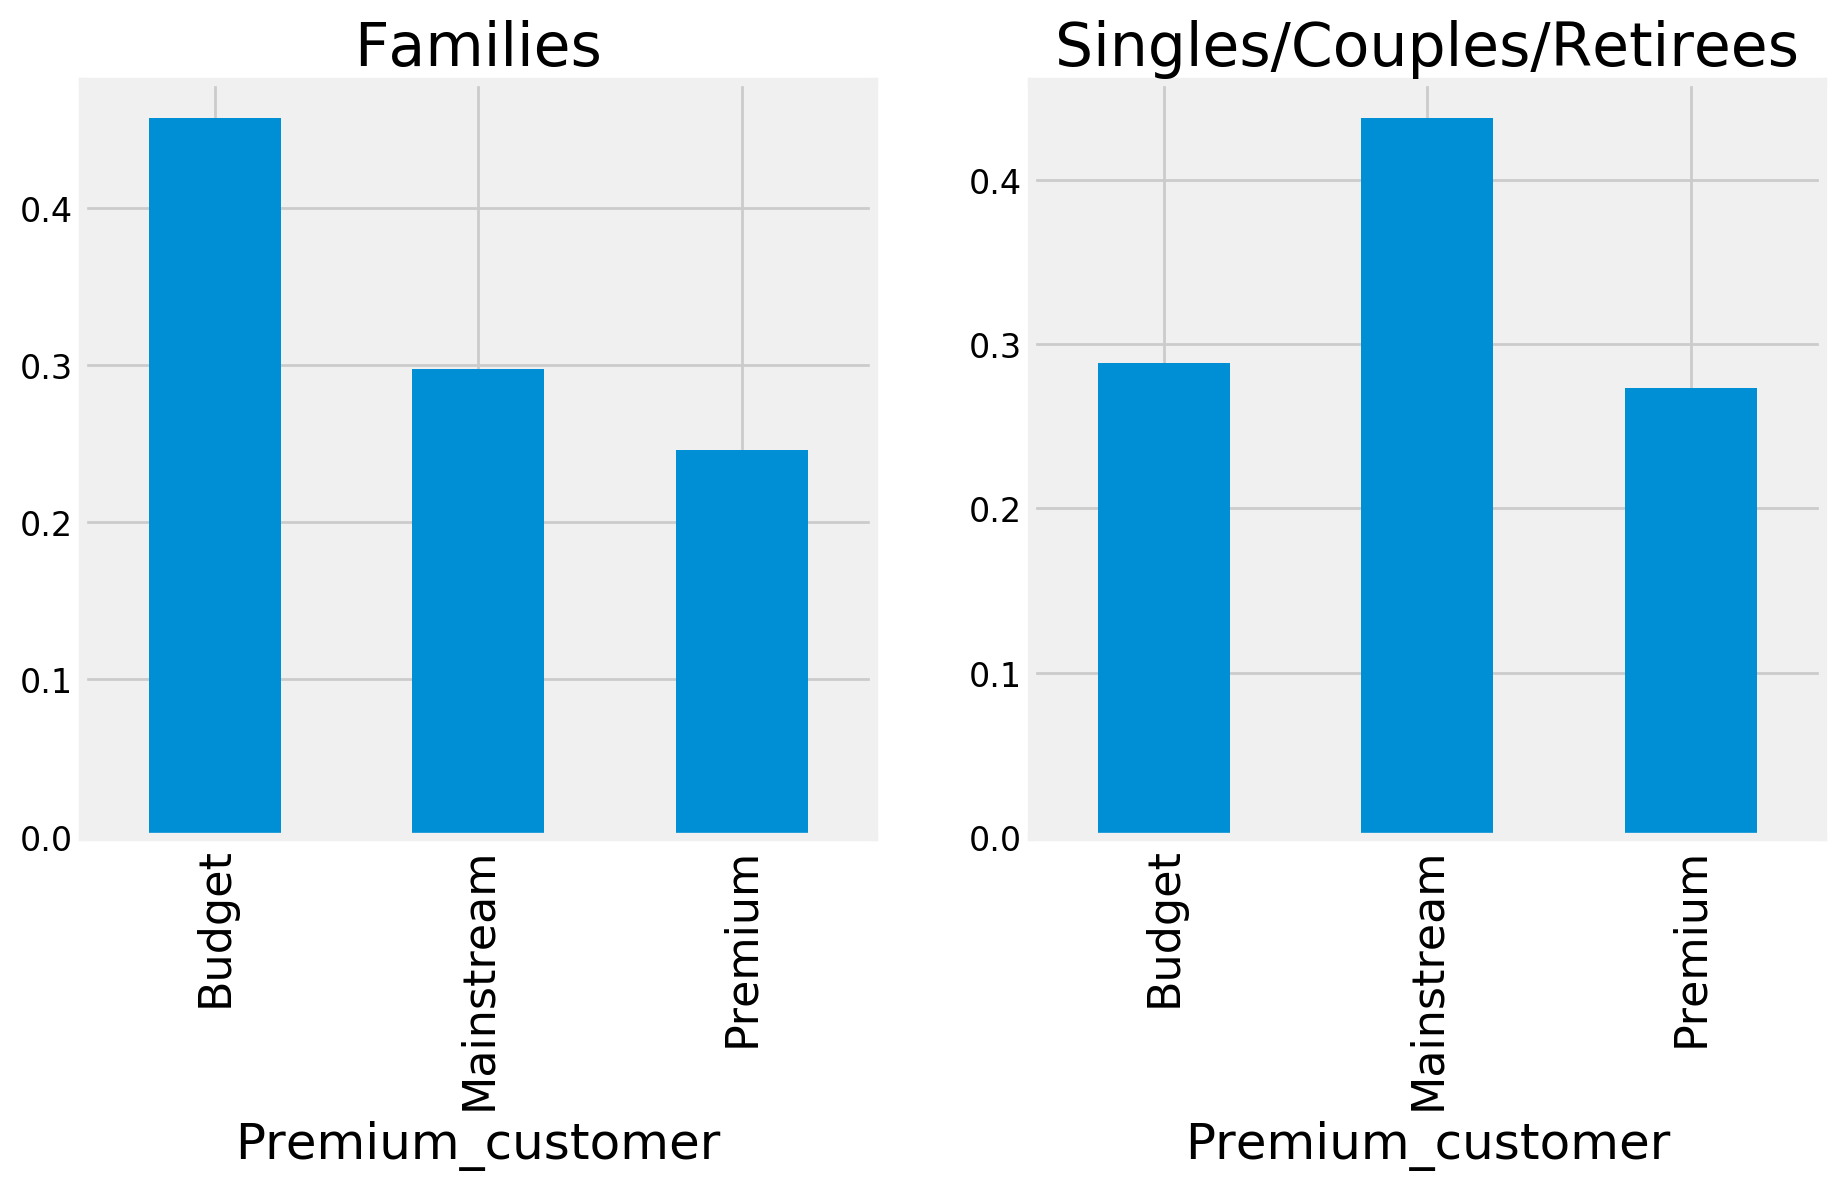

In [26]:
df['Family'] = df['Lifestage'].apply(lambda x: 'Family' if 'FAMILIES' in x else 'Single/Couple')
font = {'size' : 15}
mpl.rc('font', **font)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5), dpi = 200)
df.groupby('Family').Premium_customer.value_counts(normalize = True).loc['Family'].plot(kind = 'bar', ax = ax1)
ax1.set_title('Families')
df.groupby('Family').Premium_customer.value_counts(normalize = True).loc['Single/Couple'].sort_index().plot(kind = 'bar',
                                                                                                            ax = ax2)
ax2.set_title('Singles/Couples/Retirees')

This confirm my initial hypothesis: families pay more attention on price rather than single/couples. This can be translated in specific business actions: supermarkets can take advantage to this price sensitivity applying discount on chips that have some difficulties to be sold. This will attract families and will help the supermarkets to manage stocks.

Now that we understood which categories make more transactions, we can analyze if the extracted match with consideration about the revenues

Text(0.5, 1.0, 'Singles/Couples/Retirees')

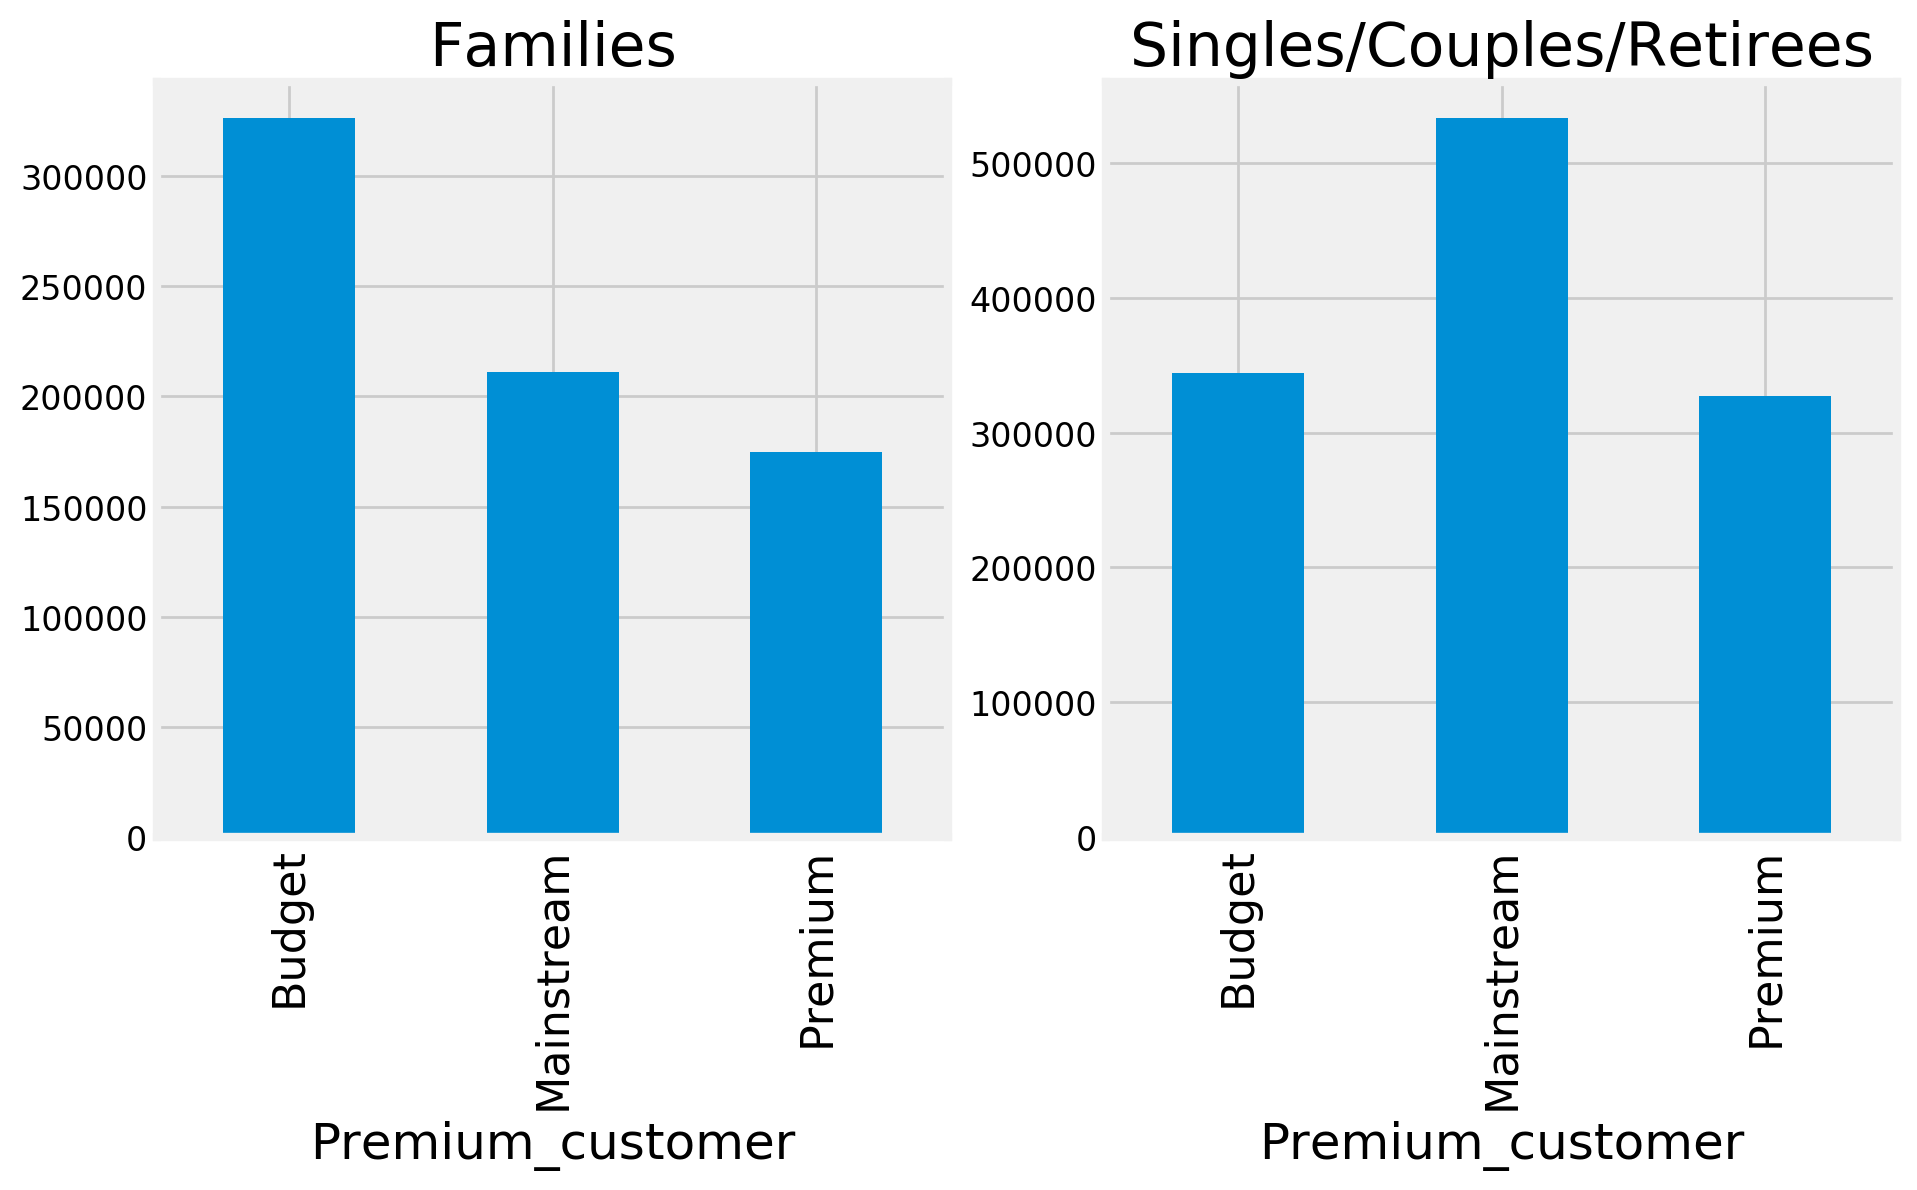

In [27]:
df['Family'] = df['Lifestage'].apply(lambda x: 'Family' if 'FAMILIES' in x else 'Single/Couple')
font = {'size' : 15}
mpl.rc('font', **font)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5), dpi = 200)
df.groupby(['Family', 'Premium_customer']).Tot_sales.sum().loc['Family'].plot(kind = 'bar', ax = ax1)
ax1.set_title('Families')
df.groupby(['Family', 'Premium_customer']).Tot_sales.sum().loc['Single/Couple'].sort_index().plot(kind = 'bar', ax = ax2)
ax2.set_title('Singles/Couples/Retirees')

It is pretty simple to identify a strong correlation between the number of order and the total revenue, but what drives the higher revenue among Other categories rather than families? This can be simply due to the higher number of segment in this category (4 vs 3). Let us compute the average expenditure on each pack of chips for these categories

In [28]:
print('Families average expenditure for pack:')
print(df.groupby(['Family', 'Premium_customer']).Unit_price.mean().loc['Family'])
print()
print()
print('Single/Couples/Retirees average expenditure for pack:')
print(df.groupby(['Family', 'Premium_customer']).Unit_price.mean().loc['Single/Couple'].sort_index())

Families average expenditure for pack:
Premium_customer
Budget        3.788158
Mainstream    3.770003
Premium       3.772504
Name: Unit_price, dtype: float64


Single/Couples/Retirees average expenditure for pack:
Premium_customer
Budget        3.862784
Mainstream    3.951401
Premium       3.873532
Name: Unit_price, dtype: float64


As we can see families tend to buy cheaper chips. I will do an indipendent T test to check if there is statistical significance

In [29]:
from scipy.stats import ttest_ind

P_Family = df['Unit_price'].loc[(df['Family'] == 'Family') & (df['Premium_customer'] == 'Budget')]
P_Other = df['Unit_price'].loc[(df['Family'] == 'Single/Couple') & (df['Premium_customer'] == 'Budget')]
M_Family = df['Unit_price'].loc[(df['Family'] == 'Family') & (df['Premium_customer'] == 'Mainstream')]
M_Other = df['Unit_price'].loc[(df['Family'] == 'Single/Couple') & (df['Premium_customer'] == 'Mainstream')]
Pr_Family = df['Unit_price'].loc[(df['Family'] == 'Family') & (df['Premium_customer'] == 'Premium')]
Pr_Other = df['Unit_price'].loc[(df['Family'] == 'Single/Couple') & (df['Premium_customer'] == 'Premium')]

print('P value of T test on Budget family/others: ', ttest_ind(P_Family, P_Other)[1])
print('P value of T test on Budget family/others: ', ttest_ind(M_Family, M_Other)[1])
print('P value of T test on Budget family/others: ', ttest_ind(Pr_Family, Pr_Other)[1])

P value of T test on Budget family/others:  6.465456908849672e-25
P value of T test on Budget family/others:  3.663284169099466e-130
P value of T test on Budget family/others:  9.29582140122153e-31


The three p-value show how the difference is significant, so this can be an important point to target the two categories

#### Understanding the products

As i did for the customers segments, i am going to analyze products in a recursive way. This time i will not dive into each of the Lifestage category, but instead i am going to use the Family variable i computed before

Text(0.5, 1.0, 'Single/Couple')

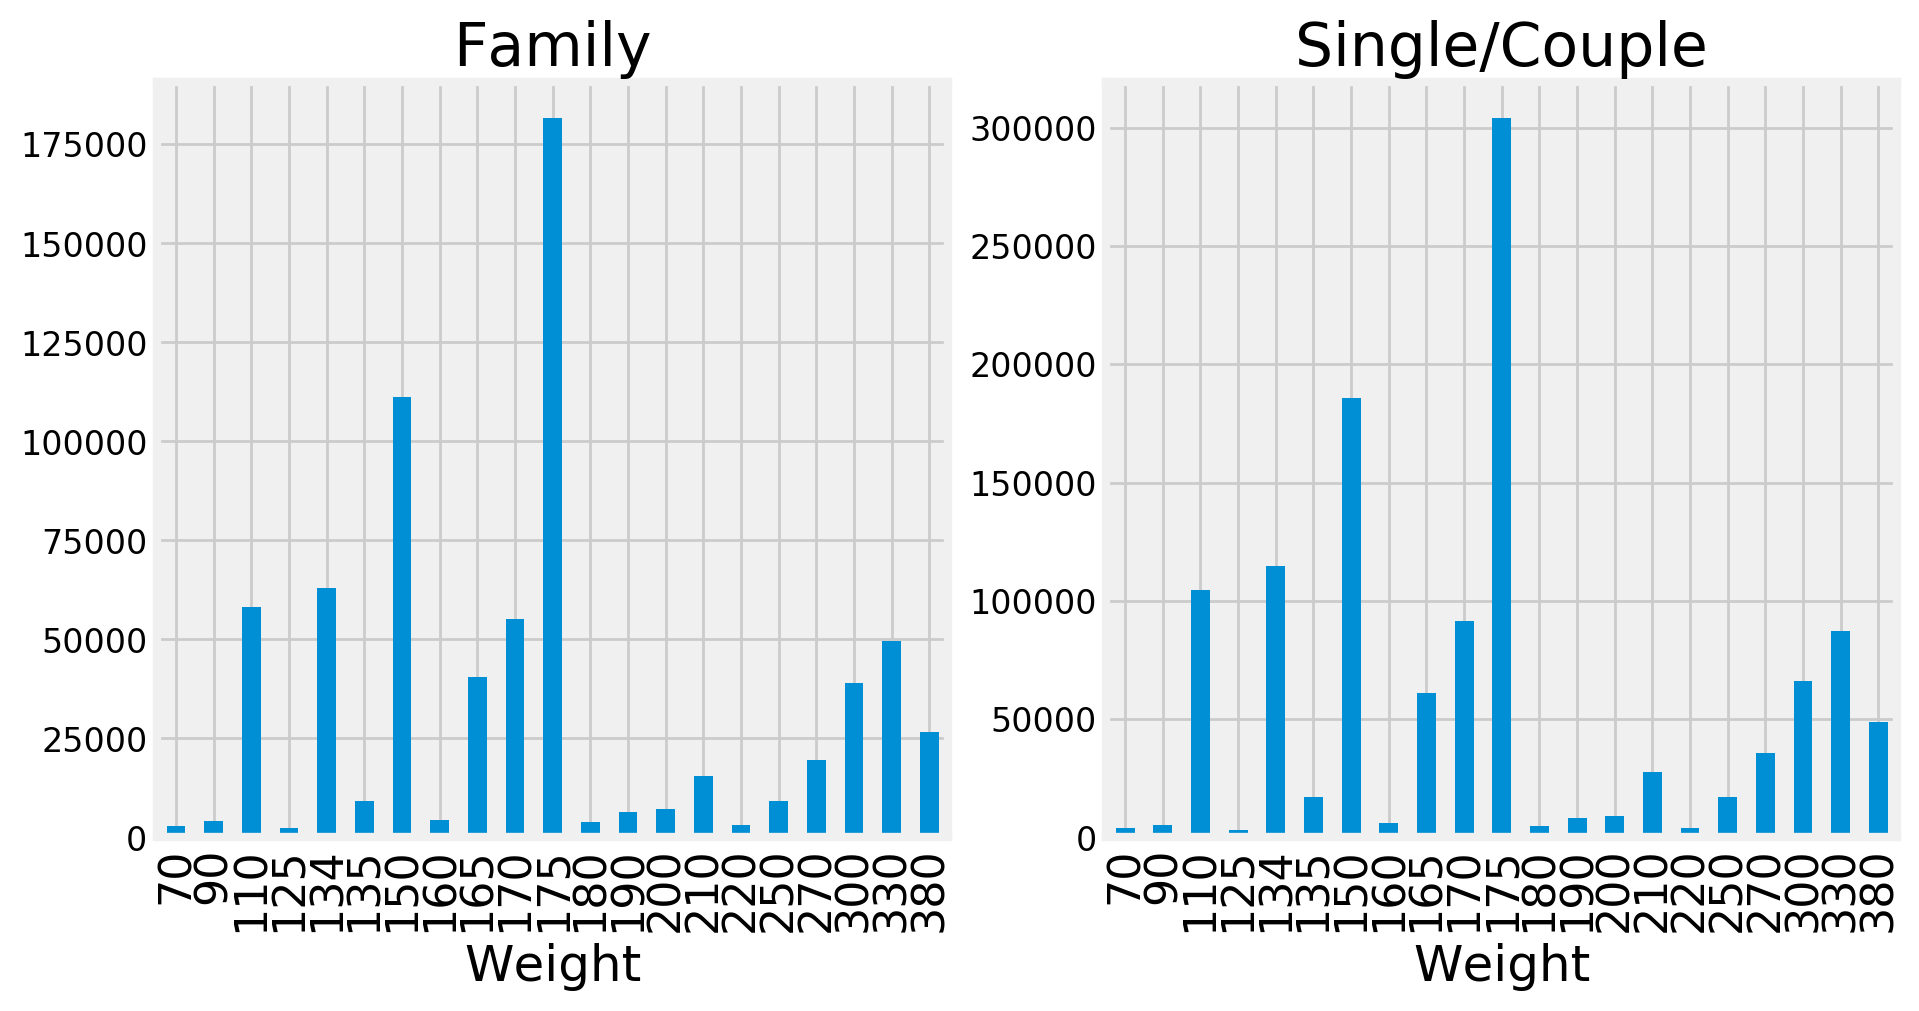

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5), dpi = 200)
df.loc[df.Family == 'Family'].groupby('Weight').Tot_sales.sum().sort_index().plot(kind = 'bar', ax = ax1)
df.loc[df.Family == 'Single/Couple'].groupby('Weight').Tot_sales.sum().sort_index().plot(kind = 'bar', ax = ax2)
ax1.set_title('Family'); ax2.set_title('Single/Couple')

The two distributions seem to be very similar, even though we are analyzing different segment. Let us go ahead and try to find out something about the other products features

Text(0.5, 1.0, 'Single/Couple (flavour by sales)')

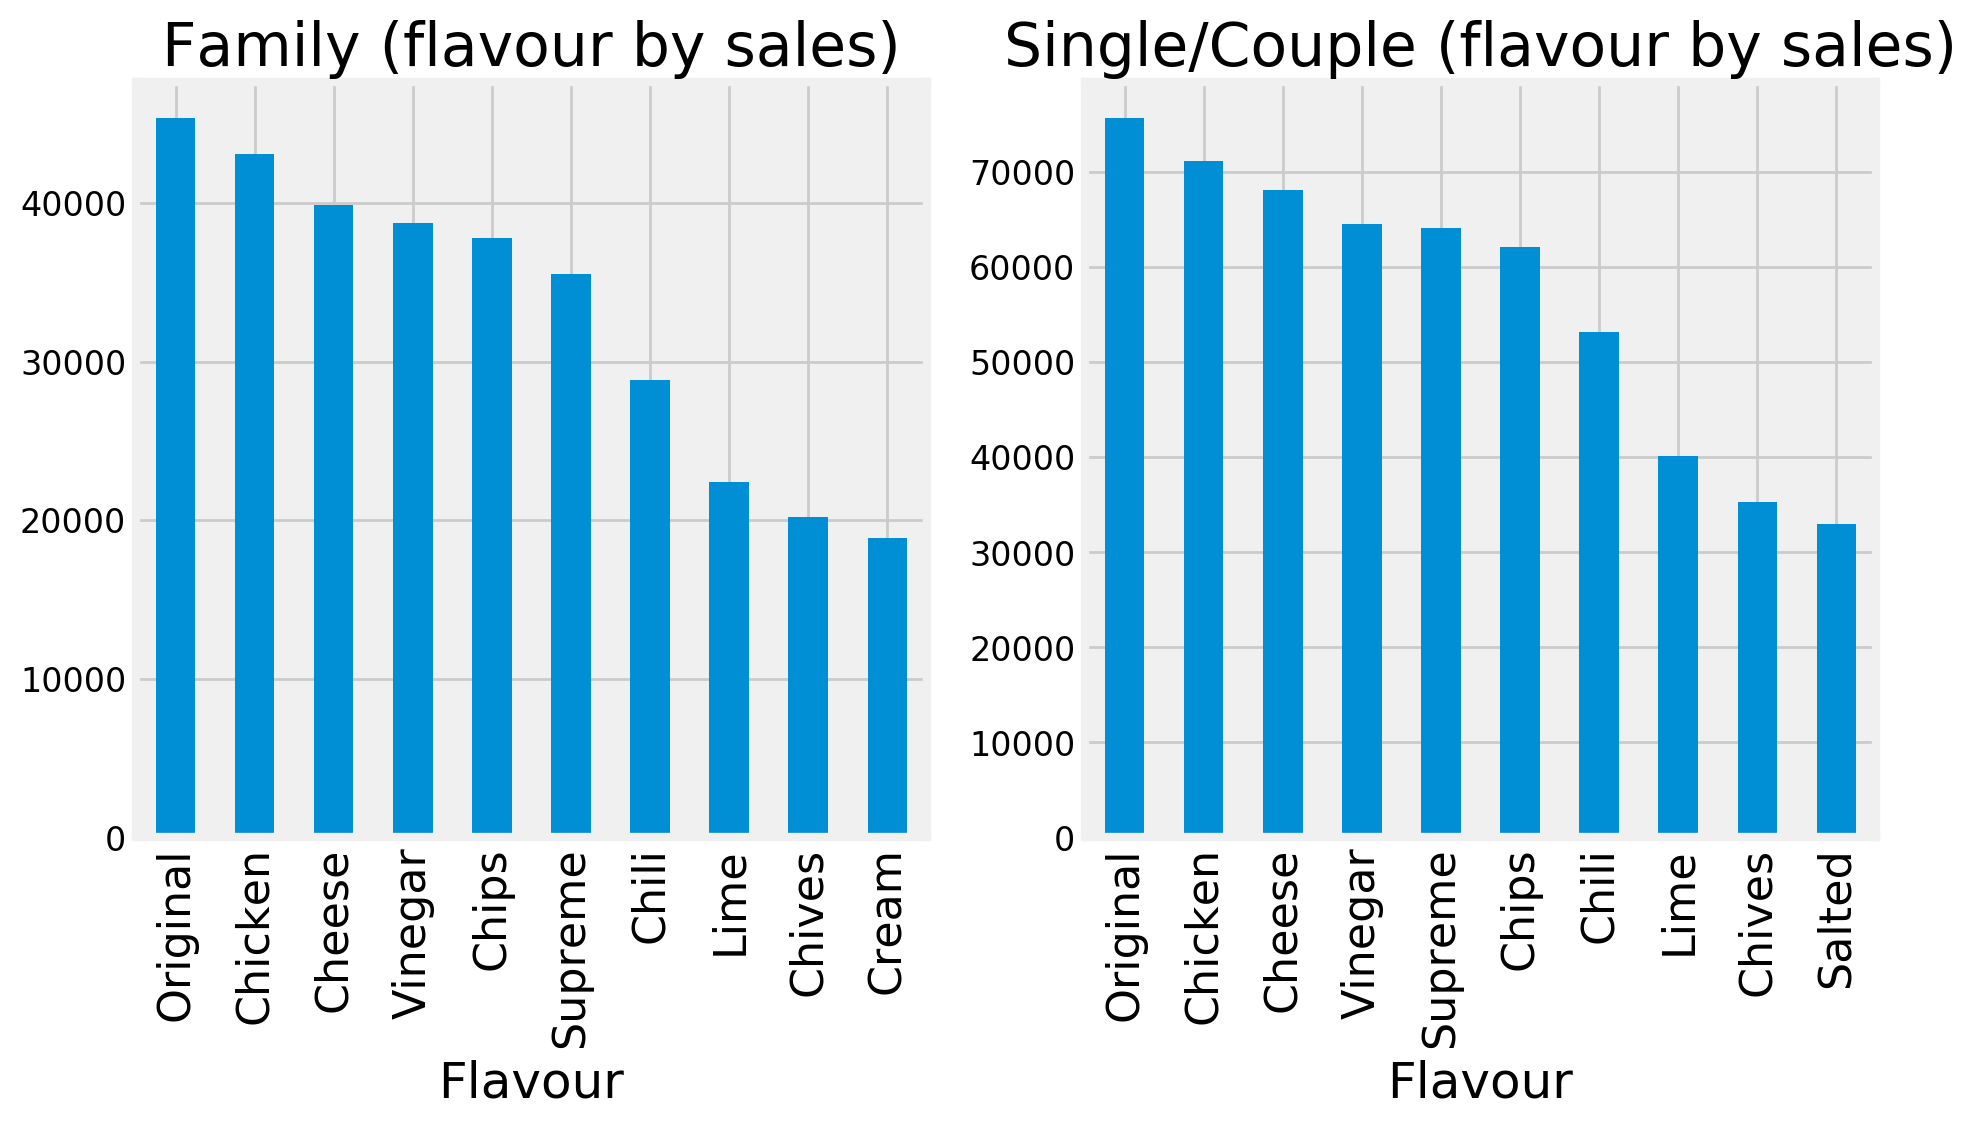

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5), dpi = 200)
df.loc[df.Family == 'Family'].groupby('Flavour').Tot_sales.sum().sort_values(ascending = False)[:10].plot(kind = 'bar', ax = ax1)
df.loc[df.Family == 'Single/Couple'].groupby('Flavour').Tot_sales.sum().sort_values(ascending = False)[:10].plot(kind = 'bar', ax = ax2)
ax1.set_title('Family (flavour by sales)'); ax2.set_title('Single/Couple (flavour by sales)')

Text(0.5, 1.0, 'Single/Couple (brand by sales)')

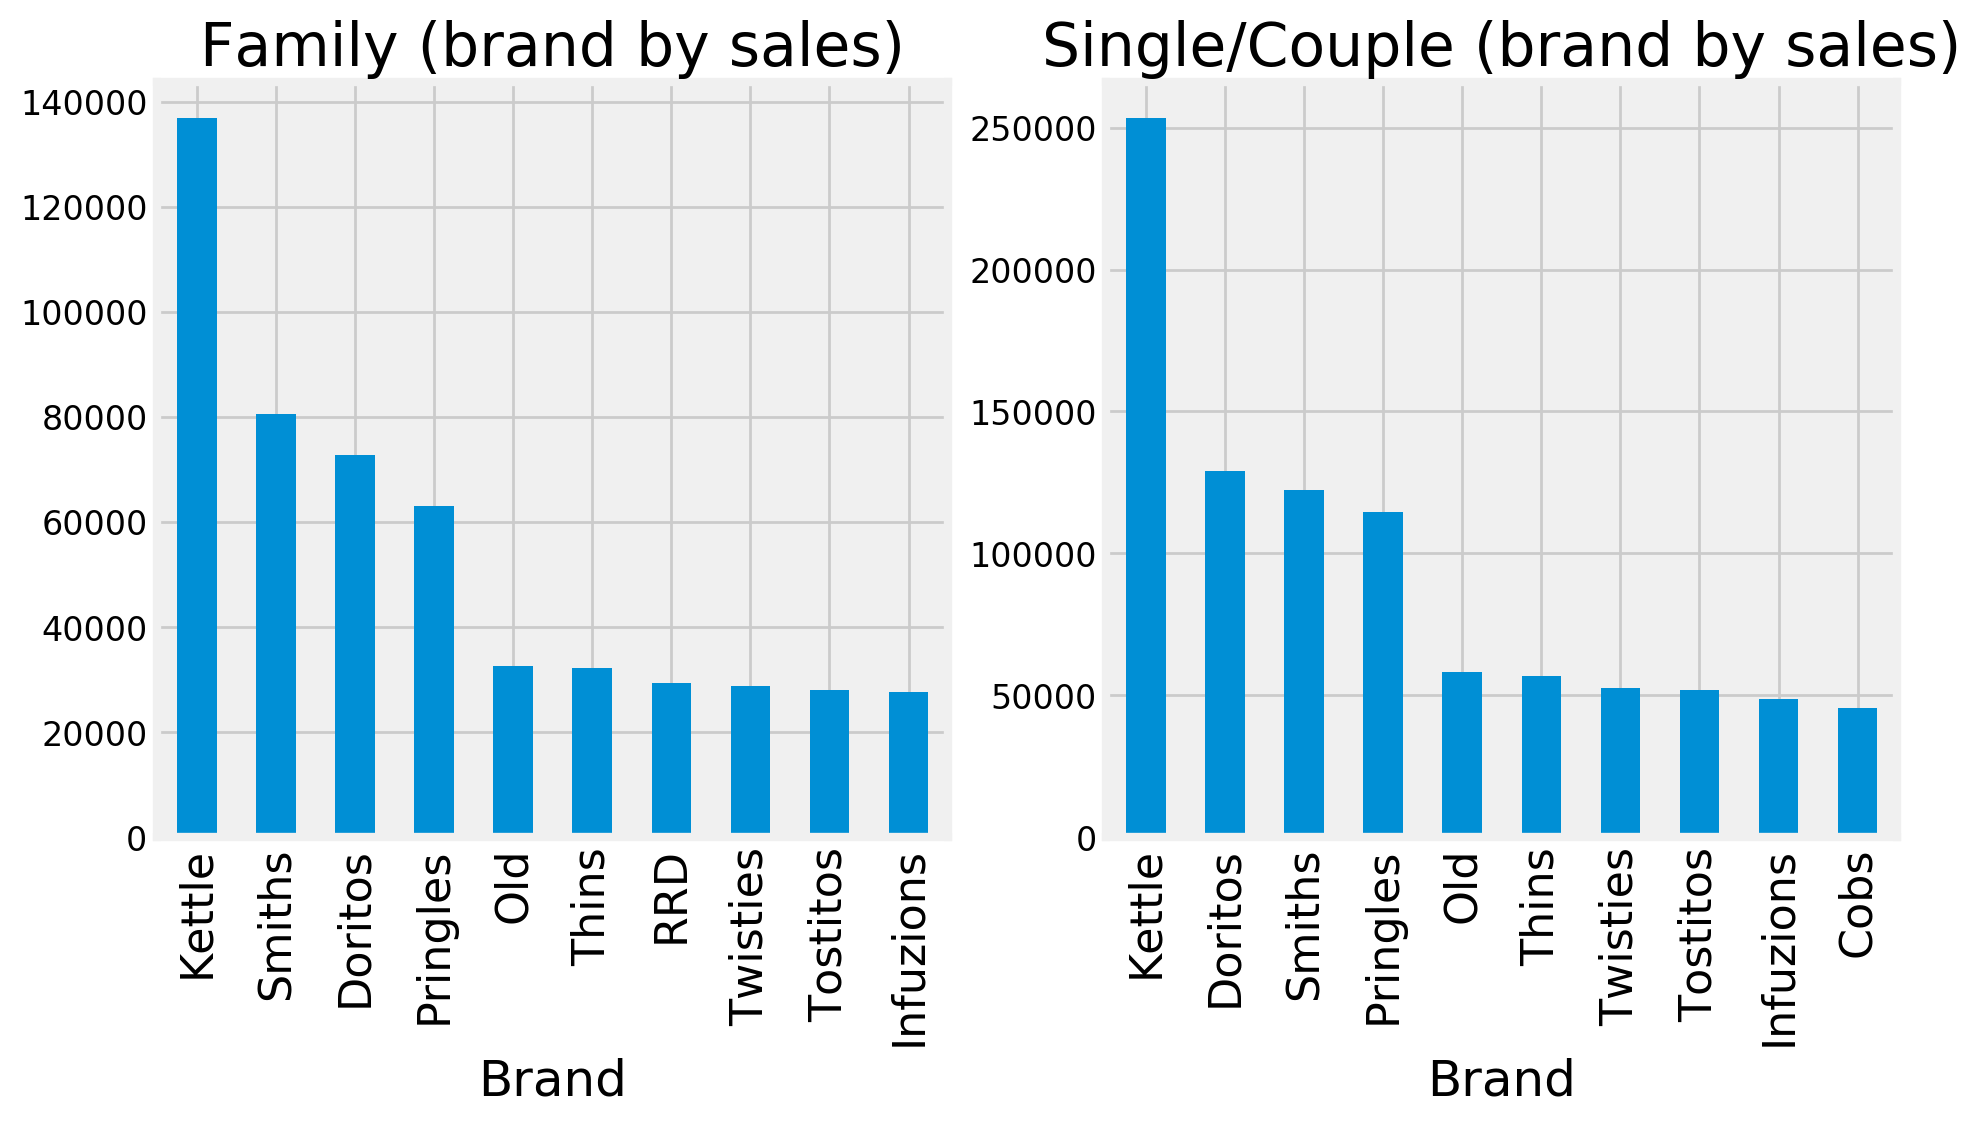

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5), dpi = 200)
df.loc[df.Family == 'Family'].groupby('Brand').Tot_sales.sum().sort_values(ascending = False)[:10].plot(kind = 'bar', ax = ax1)
df.loc[df.Family == 'Single/Couple'].groupby('Brand').Tot_sales.sum().sort_values(ascending = False)[:10].plot(kind = 'bar', ax = ax2)
ax1.set_title('Family (brand by sales)'); ax2.set_title('Single/Couple (brand by sales)')

It seems that the two different segments have almost the same tastes in terms of flavour: Instead, when we look at the Brand we can notice some differences. We can compute the difference in percentage to understand which brands are more relevant

In [33]:
(df.loc[df.Family == 'Single/Couple'].groupby('Brand').Tot_sales.sum().sort_values(ascending = False)[:10] - df.loc[df.Family == 'Family'].groupby('Brand').Tot_sales.sum().sort_values(ascending = False)[:10]) / df.loc[df.Family == 'Family'].groupby('Brand').Tot_sales.sum().sort_values(ascending = False)[:10]

Brand
Cobs              NaN
Doritos      0.772794
Infuzions    0.751489
Kettle       0.851313
Old          0.780103
Pringles     0.820761
RRD               NaN
Smiths       0.519414
Thins        0.764090
Tostitos     0.847676
Twisties     0.829076
Name: Tot_sales, dtype: float64

'Cobs' and 'RRD' have NaN values since they just appear in one rank. We also want to have a look to Smiths since there is a smaller difference in consumption among the two segments

In [34]:
print('Average pack price: ', df.groupby('Brand').Unit_price.mean().sort_values(ascending = False).mean())
print()
print(df.groupby('Brand').Unit_price.mean().sort_values(ascending = False))

Average pack price:  3.4060544152151846

Brand
Dorito        6.368285
Old           5.099398
Kettle        4.936630
Cheezels      4.562829
Twisties      4.499439
Tostitos      4.400000
Doritos       4.220511
Tyrrells      4.199783
Smiths        3.897267
Cobs          3.800000
Infzns        3.800000
Pringles      3.699838
Infuzions     3.609017
Grain         3.599464
Thins         3.299742
GrnWves       3.100000
Cheetos       3.052648
French        3.000000
Natural       3.000000
NCC           3.000000
RRD           2.886712
Red           2.699771
Smith         2.600000
Burger        2.300000
CCs           2.100000
WW            1.844244
Woolworths    1.800000
Sunbites      1.700000
Snbts         1.700000
Name: Unit_price, dtype: float64


'RDD' it is significantly below the avg price, so this can be one of the reasons beacuse it is more popular among families

#### Seasonality

Last check, i can investigate about possible trends in the buying habits of our customers. Since i want to heavly penalize outliers, i am going to use a strong rolling mean (30 days) on the total sales

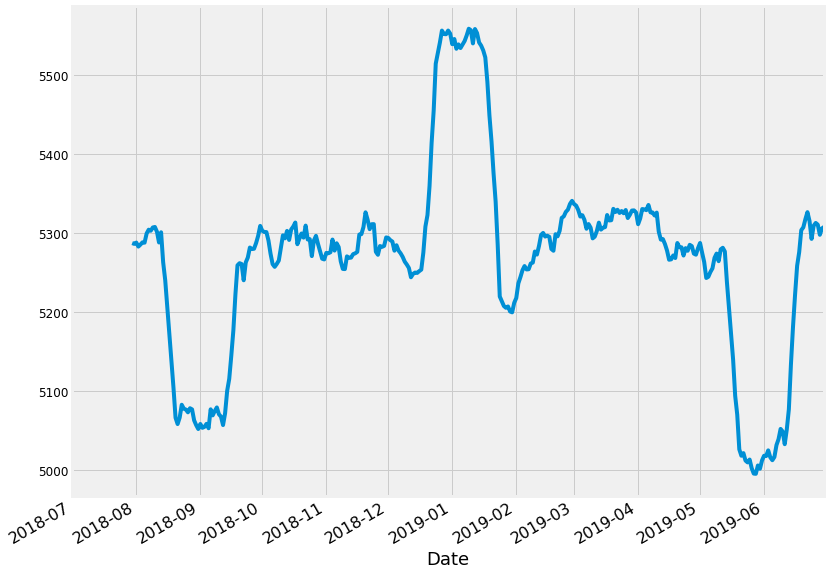

In [35]:
fig = plt.figure(figsize = (12, 10))
df.groupby('Date').Tot_sales.sum().rolling(30).mean().plot()

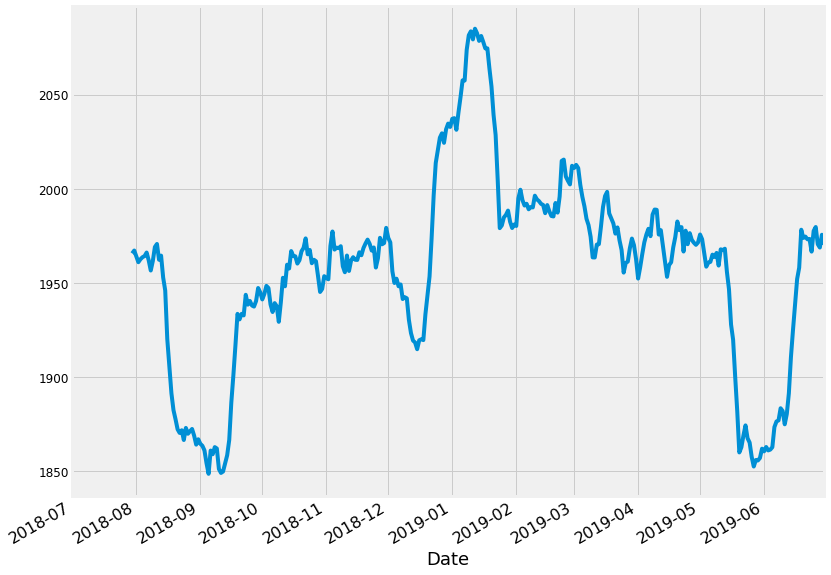

In [36]:
fig = plt.figure(figsize = (12, 10))
df.loc[df.Family == 'Family'].groupby('Date').Tot_sales.sum().rolling(30).mean().plot()

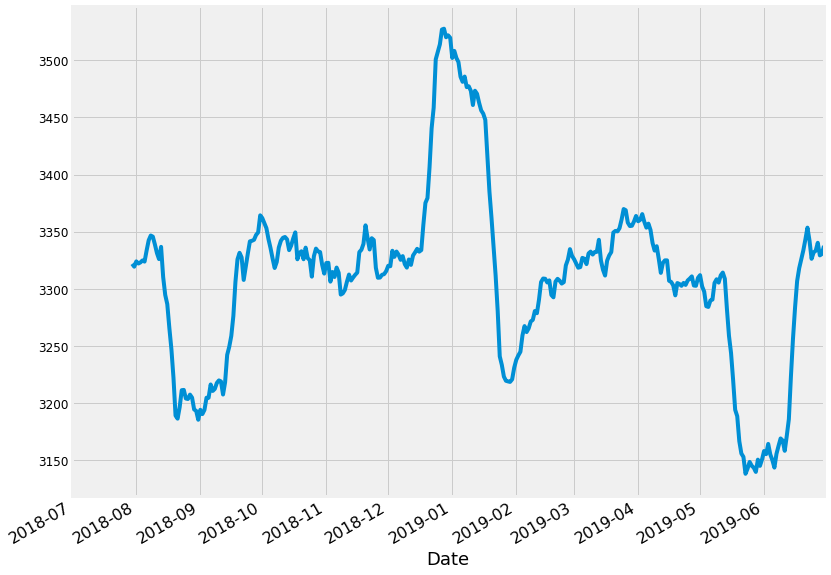

In [37]:
fig = plt.figure(figsize = (12, 10))
df.loc[df.Family == 'Single/Couple'].groupby('Date').Tot_sales.sum().rolling(30).mean().plot()

It turns out we have a strong presence of seasonality in our transactions, that can be helpful in forecasting level of stock. We can also see that there are some differences between the two sub-curves, expecially at the beginning of december and in the end of january

In [39]:
df.to_csv(r'C:\Users\Aless\Downloads\Task2_data.csv')